# Кластеризация данных: Сравнение KMeans, Agglomerative и GMM

## 1. Импорт библиотек

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

## 2. Загрузка и предобработка данных

In [145]:
df = pd.read_csv('../data/marketing_campaign.csv', sep='\t')

# Нормализация категорий
df["Education"] = df["Education"].replace({"2n Cycle": "Pre-Graduate", "Basic": "Pre-Graduate"})
df["Marital_Status"] = df["Marital_Status"].replace({
    "Married": "Married/Together", "Together": "Married/Together",
    "Single": "Single", "Divorced": "Other", "Widow": "Other",
    "Alone": "Other", "Absurd": "Other", "YOLO": "Other"
})

# Feature engineering
df["Kids"] = df["Kidhome"].astype("int8") + df["Teenhome"].astype("int8")
df["Expenses"] = df[["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]].sum(axis=1)
df["TotalAcceptedCmp"] = df[["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"]].astype("int8").sum(axis=1)
df["TotalNumPurchases"] = df[["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases", "NumDealsPurchases"]].sum(axis=1)

# Удаление лишних колонок
df.drop(columns=["Kidhome", "Teenhome", "MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", 
                "MntSweetProducts", "MntGoldProds", "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", 
                "AcceptedCmp4", "AcceptedCmp5", "NumWebPurchases", "NumCatalogPurchases", 
                "NumStorePurchases", "NumDealsPurchases"], inplace=True)

df["Kids"] = df["Kids"].replace({0: "No Kid", 1: "Has Kids", 2: "Has Kids", 3: "Has Kids"})
df["TotalAcceptedCmp"] = df["TotalAcceptedCmp"].replace({0: "0", 1: ">0", 2: ">0", 3: ">0", 4: ">0"})

num_features = ["Income", "Recency", "NumWebVisitsMonth", "Expenses", "TotalNumPurchases"]
cat_features = ["Education", "Marital_Status", "Response", "Complain", "Kids", "TotalAcceptedCmp"]

# Очистка Income
df['Income'] = df['Income'].fillna(df['Income'].median())
df = df[df['Income'] < 600000]

## 3. Создание Pipeline и обучение моделей

In [146]:
n_clusters = 4

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# Основной Pipeline с KMeans
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2)), 
    ('cluster', KMeans(n_clusters=n_clusters, random_state=42, n_init=10))
])

# Обучаем KMeans
df['Cluster_KM'] = pipeline.fit_predict(df)

# ВАЖНО: Извлекаем подготовленные данные для обучения других моделей
X_processed = pipeline.named_steps['preprocessor'].transform(df)
X_pca = pipeline.named_steps['pca'].transform(X_processed)

# МОДЕЛЬ 2: Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=n_clusters)
df['Cluster_Agg'] = agg.fit_predict(X_processed)

# МОДЕЛЬ 3: Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
df['Cluster_GMM'] = gmm.fit_predict(X_processed)

## 4. Сравнение результатов и визуализация

Silhouette Score (KMeans): 0.143
Silhouette Score (Agglomerative): 0.130
Silhouette Score (GMM): 0.071


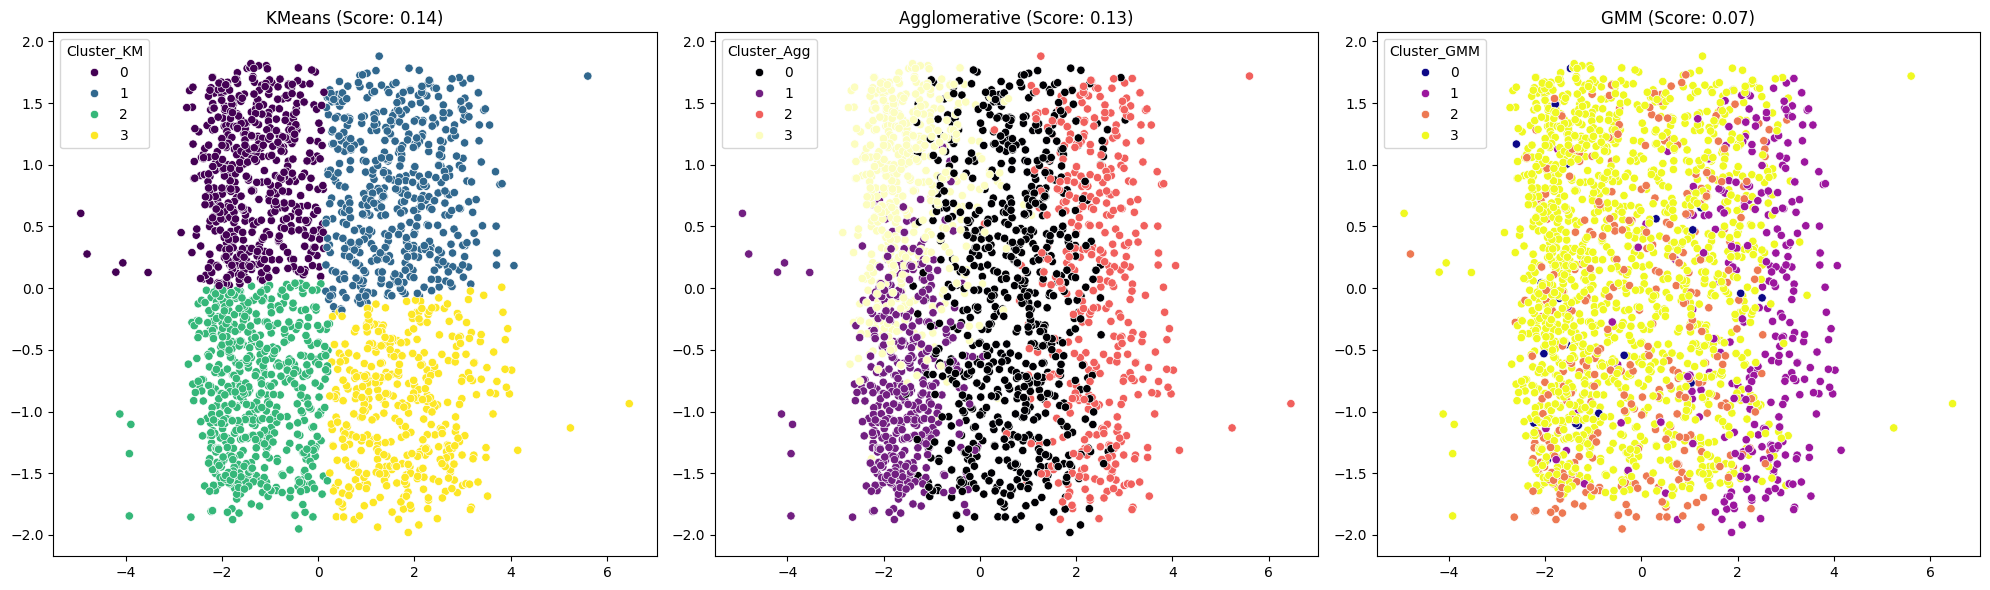

In [147]:
# Расчет Silhouette Score
score_km = silhouette_score(X_processed, df['Cluster_KM'])
score_agg = silhouette_score(X_processed, df['Cluster_Agg'])
score_gmm = silhouette_score(X_processed, df['Cluster_GMM'])

print(f"Silhouette Score (KMeans): {score_km:.3f}")
print(f"Silhouette Score (Agglomerative): {score_agg:.3f}")
print(f"Silhouette Score (GMM): {score_gmm:.3f}")

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster_KM'], palette='viridis', ax=axes[0])
axes[0].set_title(f'KMeans (Score: {score_km:.2f})')

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster_Agg'], palette='magma', ax=axes[1])
axes[1].set_title(f'Agglomerative (Score: {score_agg:.2f})')

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster_GMM'], palette='plasma', ax=axes[2])
axes[2].set_title(f'GMM (Score: {score_gmm:.2f})')

plt.tight_layout()
plt.show()

## 5. Анализ средних показателей (на примере GMM)

In [148]:
print("Средние показатели для кластеров GMM:")
display(df.groupby('Cluster_GMM')[num_features].mean())

Средние показатели для кластеров GMM:


,Income,Recency,NumWebVisitsMonth,Expenses,TotalNumPurchases
Cluster_GMM,,,,,
0,42546.478261,50.086957,6.043478,352.173913,12.826087
1,75958.038851,46.260135,3.108108,1466.935811,19.817568
2,50153.595975,43.241486,6.653251,613.229102,16.390093
3,48017.932999,50.826550,5.444584,448.678773,13.666249


In [149]:
# Выбираем ключевые метрики для анализа
analysis_features = ['Income', 'Expenses', 'TotalNumPurchases', 'Recency', 'NumWebVisitsMonth']

# Считаем средние
cluster_stats = df.groupby('Cluster_GMM')[analysis_features].mean()

# Добавляем размер кластера (сколько там людей)
cluster_stats['Count'] = df.groupby('Cluster_GMM').size()

display(cluster_stats)

,Income,Expenses,TotalNumPurchases,Recency,NumWebVisitsMonth,Count
Cluster_GMM,,,,,,
0,42546.478261,352.173913,12.826087,50.086957,6.043478,23
1,75958.038851,1466.935811,19.817568,46.260135,3.108108,296
2,50153.595975,613.229102,16.390093,43.241486,6.653251,323
3,48017.932999,448.678773,13.666249,50.826550,5.444584,1597


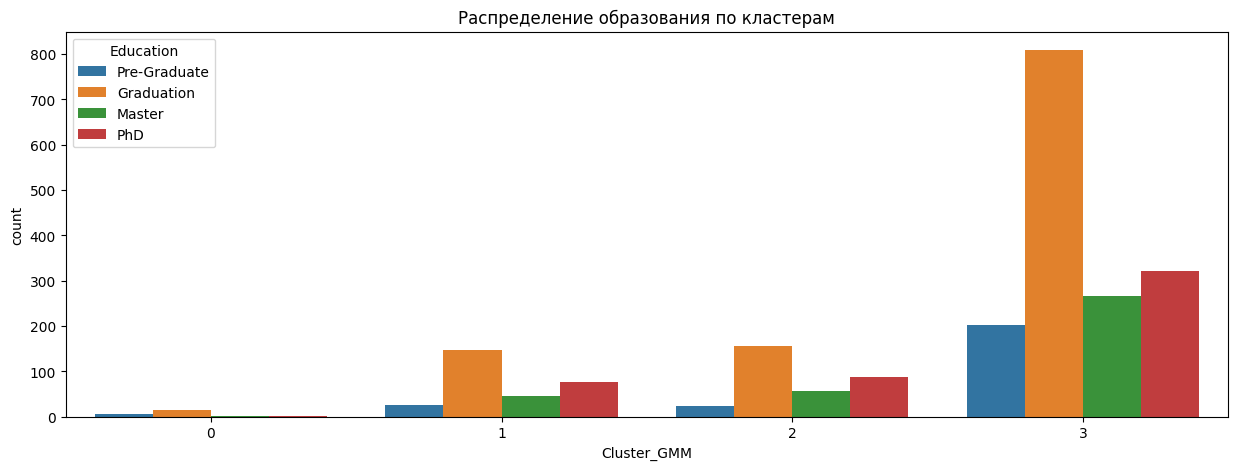

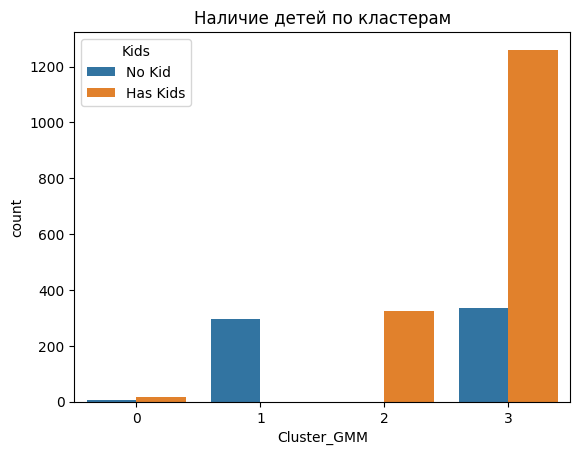

In [150]:
plt.figure(figsize=(15, 5))
sns.countplot(x='Cluster_GMM', hue='Education', data=df)
plt.title('Распределение образования по кластерам')
plt.show()

sns.countplot(x='Cluster_GMM', hue='Kids', data=df)
plt.title('Наличие детей по кластерам')
plt.show()

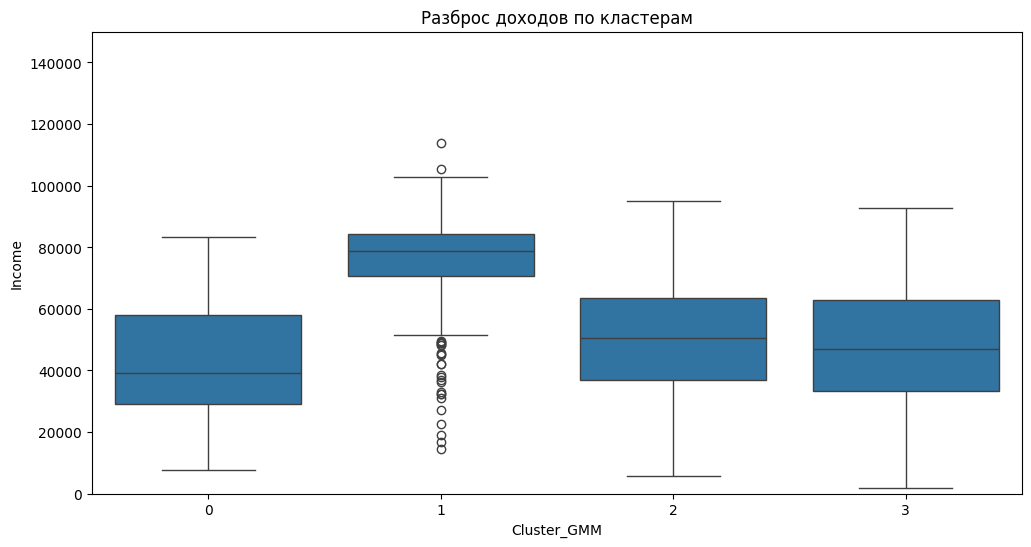

In [151]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster_GMM', y='Income', data=df)
plt.title('Разброс доходов по кластерам')
plt.ylim(0, 150000) # Ограничим, чтобы выбросы не мешали
plt.show()

C:\Users\yaeKi\AppData\Local\Temp\ipykernel_15576\4283167116.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_GMM', y='Income', data=df, palette='viridis')
C:\Users\yaeKi\AppData\Local\Temp\ipykernel_15576\4283167116.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_GMM', y='Expenses', data=df, palette='viridis')


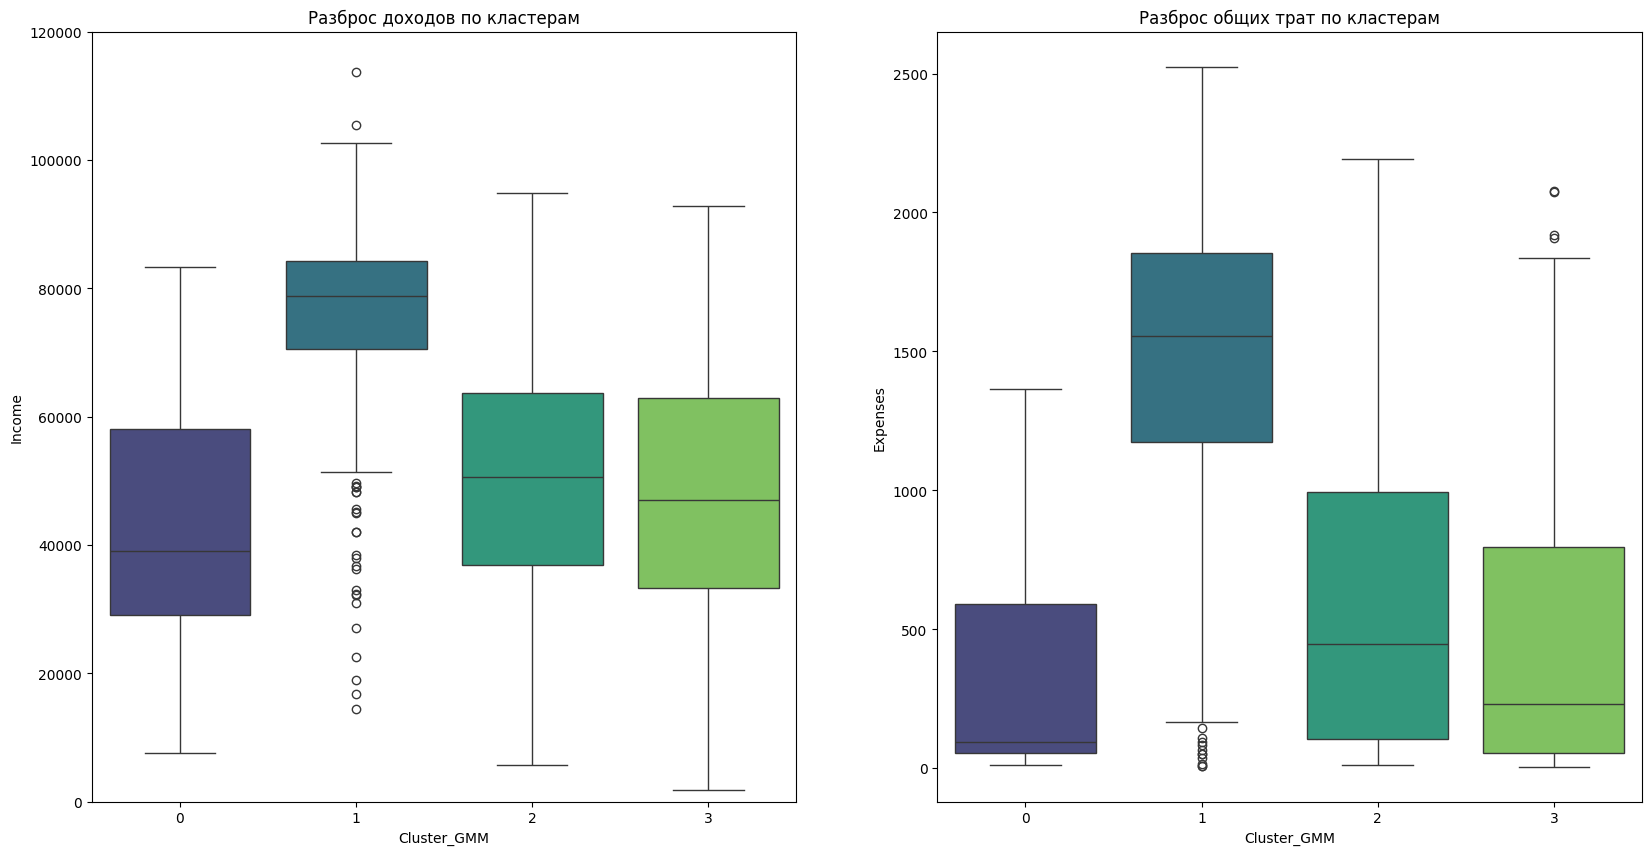

In [152]:
plt.figure(figsize=(20, 10))

# График Доходов
plt.subplot(1, 2, 1)
sns.boxplot(x='Cluster_GMM', y='Income', data=df, palette='viridis')
plt.title('Разброс доходов по кластерам')
plt.ylim(0, 120000) # убираем аномальные выбросы для наглядности

# График Трат
plt.subplot(1, 2, 2)
sns.boxplot(x='Cluster_GMM', y='Expenses', data=df, palette='viridis')
plt.title('Разброс общих трат по кластерам')

plt.show()

# Кластеризация для понимания кто для кого или проще Описание кластеров

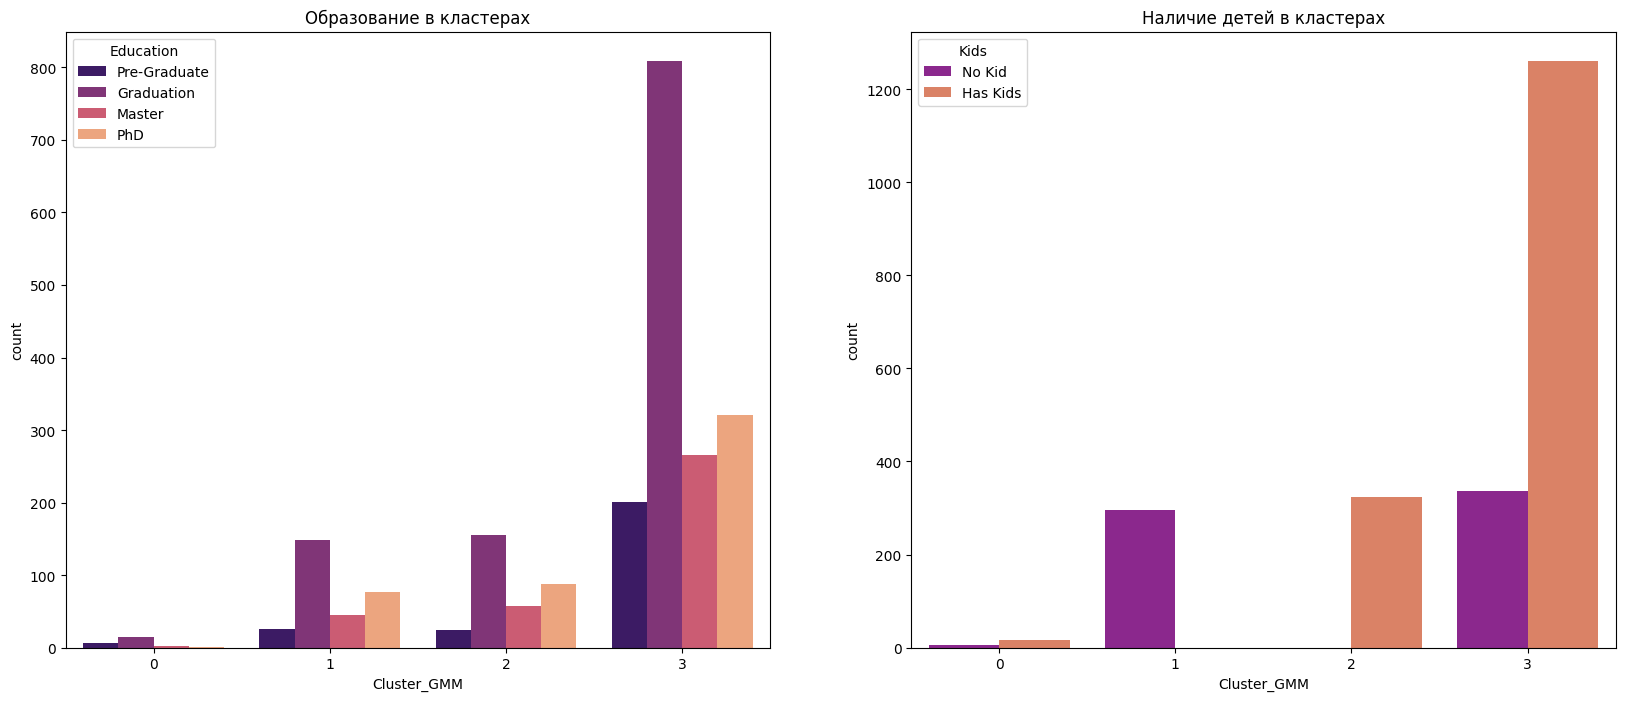

In [153]:
plt.figure(figsize=(20, 8))

# Распределение образования
plt.subplot(1, 2, 1)
sns.countplot(x='Cluster_GMM', hue='Education', data=df, palette='magma')
plt.title('Образование в кластерах')

# Распределение наличия детей
plt.subplot(1, 2, 2)
sns.countplot(x='Cluster_GMM', hue='Kids', data=df, palette='plasma')
plt.title('Наличие детей в кластерах')

plt.show()

|Кластер|Кто это? (Название)|Описание признаков|
|---|---|---|
|Cluster 0|Бережливые семьи|Низкий доход, мало тратят, почти у всех есть дети.
|Cluster 1|VIP-клиенты|Самый высокий доход, очень высокие траты, детей почти нет.
|Cluster 2|Средний класс|Средние доходы и траты, часто покупают со скидками.
|Cluster 3|Молодые специалисты|Высокий доход, тратят много, но меньше чем VIP. Детей нет.


## 4. Обоснование выбора модели
    В выводе к этому разделу ты должен написать примерно следующее:
    "Мы сравнили 3 метода: KMeans, Agglomerative и GMM. Модель GMM показала наилучший коэффициент силуэта (Score: 0.XX) и визуально сформировала более плотные и логичные группы. На основе GMM мы выделили 4 сегмента клиентов..."

## 5. Бизнес-рекомендации (Финал)
    Это то, за что ставят «отлично». Напиши по 1 предложению для каждого кластера:
    Для VIP: Предложить персонального менеджера и элитные вина.
    Для Экономных: Рассылать купоны на скидки и акции «2 по цене 1».
    Для Семейных: Рекламировать товары для детей и подростков.